In [1]:
import os
import glob
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

from concurrent import futures
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
from scipy.stats import gaussian_kde

""" set output directory """
data_dir = "./data/mostattractive_stocks"
os.makedirs(data_dir, exist_ok=True)

In [2]:
""" datetime util """
now = dt.datetime.now()
lastday = now + relativedelta(months=0, days=-1)
firstday_of_this_month = dt.datetime(now.year, now.month, 1)
lastday_of_this_month = dt.datetime(now.year, now.month, 1) + relativedelta(months=1, days=-1)
firstday_of_last_month = dt.datetime(now.year, now.month, 1) + relativedelta(months=-1, days=0)
lastday_of_last_month = dt.datetime(now.year, now.month, 1) + relativedelta(months=0, days=-1)

In [3]:
""" set the download window """
start_date = "2017-01-01"
end_date = lastday.strftime('%Y-%m-%d')

# Data Loading

In [4]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [5]:
sp500_df = tables[0]
second_table = tables[1]
print(sp500_df.shape)

# rename symbol to escape symbol error
sp500_df["Symbol"] = sp500_df["Symbol"].map(lambda x: x.replace(".", "-"))
sp500_df.to_csv(f"./SP500_{end_date}.csv", index=False)
sp500_df = pd.read_csv(f"./SP500_{end_date}.csv")
print(sp500_df.shape)
sp500_tickers = list(sp500_df["Symbol"])
sp500_df.head()

(503, 9)
(503, 9)


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
bad_names = [] # to keep track of failed queries

def download_stock(stock):
    try: 
        # download dataframe
        data = pdr.get_data_yahoo(stock, start=start_date, end=end_date)
        data['Name'] = stock
        output_name = f"{data_dir}//{stock}.csv"
        data.to_csv(output_name)
    
    except BaseException as e:
        bad_names.append(stock)
        print(e)
        print('bad: %s' % (stock))    

In [7]:
path_failed_queries = f'{data_dir}/failed_queries.txt'
if os.path.exists(path_failed_queries):
    with open(path_failed_queries) as f:
        failed_queries = f.read().split("\n")[:-1]
        sp500_tickers_ = failed_queries
else:
    sp500_tickers_ = sp500_tickers
print("number of stockes to download:", len(sp500_tickers_))

number of stockes to download: 503


In [8]:
print(type(sp500_tickers_), len(sp500_tickers_))
# sp500_tickers_

<class 'list'> 503


# Scraping

In [9]:
for ticker in sp500_tickers_:
    download_stock(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
# # set the maximum thread number
# max_workers = 20
# now = dt.datetime.now()

# # in case a smaller number of stocks than threads was passed in
# workers = min(max_workers, len(sp500_tickers_))

# with futures.ThreadPoolExecutor(workers) as executor:
#     res = executor.map(download_stock, sp500_tickers_)
    
# """ Save failed queries to a text file to retry """
# if len(bad_names) > 0:
#     with open(path_failed_queries, 'w') as outfile:
#         for name in bad_names:
#             outfile.write(name + "\n")
                          
# finish_time = dt.datetime.now()
# duration = finish_time - now
# minutes, seconds = divmod(duration.seconds, 60)
# print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
# print(f'{len(bad_names)} stocks failed: ', bad_names)                          

# Preprocessing

In [12]:
historial_stock_data_files = glob.glob(f"{data_dir}/*.csv")
highest_day_list = []
for files in historial_stock_data_files:
    price = pd.read_csv(files, index_col="Date", parse_dates = True)
    ticker = os.path.splitext(os.path.basename(files))[0]
    price_close = price[["Close"]]
    highest_day = price_close.idxmax()[0]
    highest_price = price_close.max()[0]
    # print(f"{price_close}:{highest_day}:{highest_price}")
    highest_day_list.append(
        pd.DataFrame({"highest_day": [highest_day], "ticker": [ticker], "highest_price": highest_price }))

df = pd.concat(highest_day_list).reset_index(drop=True)
print(df.shape)
df.head()

(504, 3)


,highest_day,ticker,highest_price
0,2021-09-03,A,179.279999
1,2018-01-12,AAL,58.470001
2,2021-11-15,AAP,241.910004
3,2022-01-03,AAPL,182.009995
4,2022-04-08,ABBV,174.960007


In [13]:
df["highest_month"] = df["highest_day"].dt.to_period("M")
df = pd.merge(df, sp500_df[["Symbol", "GICS Sector", "GICS Sub-Industry"]],
              left_on='ticker', right_on='Symbol')

In [15]:
df.count()

highest_day          503
ticker               503
highest_price        503
highest_month        503
Symbol               503
GICS Sector          503
GICS Sub-Industry    502
dtype: int64

# Stock Analysis

## 최근 최고치를 경신한 주식

In [20]:
df.sort_values("highest_day", ascending=False).head(20)

,highest_day,ticker,highest_price,highest_month,Symbol,GICS Sector,GICS Sub-Industry
219,2023-01-05,HIG,77.080002,2023-01,HIG,Financials,Property & Casualty Insurance
390,2023-01-05,RE,342.140015,2023-01,RE,Financials,Reinsurance
286,2023-01-05,LW,96.029999,2023-01,LW,Consumer Staples,Packaged Foods & Meats
314,2023-01-05,MRK,113.639999,2023-01,MRK,Health Care,Pharmaceuticals
459,2023-01-05,ULTA,488.940002,2023-01,ULTA,Consumer Discretionary,Specialty Stores
231,2023-01-04,HWM,39.549999,2023-01,HWM,Industrials,Aerospace & Defense
198,2023-01-04,GEHC,60.490002,2023-01,GEHC,Health Care,NaN
79,2023-01-04,CB,224.399994,2023-01,CB,Financials,Property & Casualty Insurance
412,2022-12-27,SJM,159.880005,2022-12,SJM,Consumer Staples,Packaged Foods & Meats
447,2022-12-27,TRV,190.479996,2022-12,TRV,Financials,Property & Casualty Insurance


## 지난달 업종별 최고가 섹터

C:\Users\speed\AppData\Local\Temp\ipykernel_21080\643322409.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(industry_value_counts.index, rotation=90)


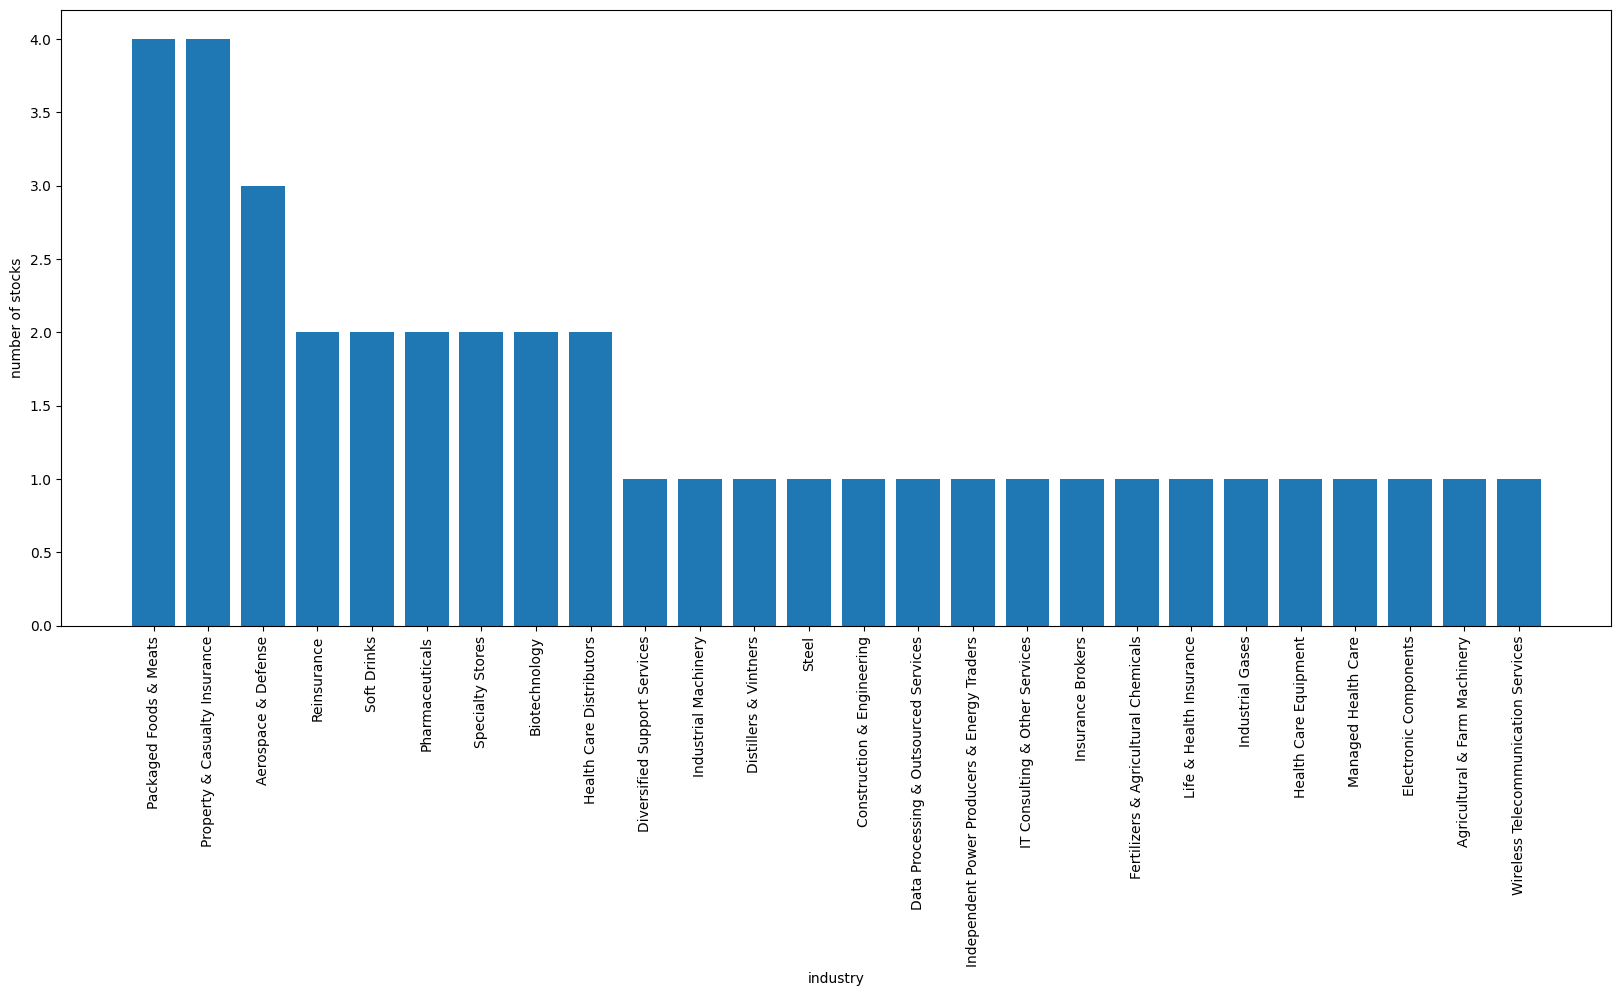

In [22]:
industry_value_counts = df[df["highest_day"] >= "2022-12-01"]["GICS Sub-Industry"].value_counts()
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(industry_value_counts.index, industry_value_counts.values)
ax.set_xticklabels(industry_value_counts.index, rotation=90)
ax.set_xlabel("industry")
ax.set_ylabel("number of stocks")
plt.show()

In [26]:
industry_value_counts[industry_value_counts.index.str.contains("Packaged Foods & Meats")]

Packaged Foods & Meats    4
Name: GICS Sub-Industry, dtype: int64

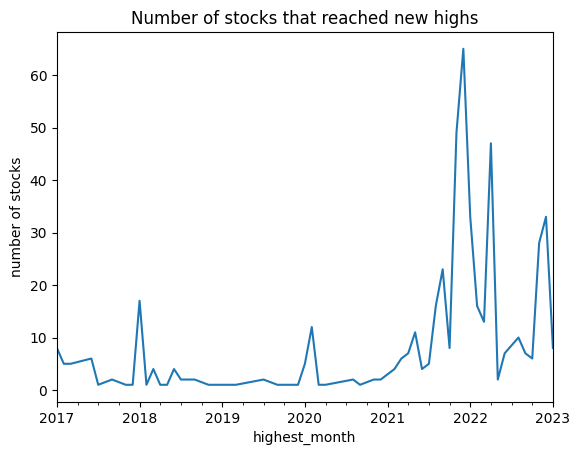

In [28]:
highest_day_count = df.groupby("highest_month").count()
highest_day_count["ticker"].plot()
plt.title("Number of stocks that reached new highs")
plt.ylabel("number of stocks")
plt.show()

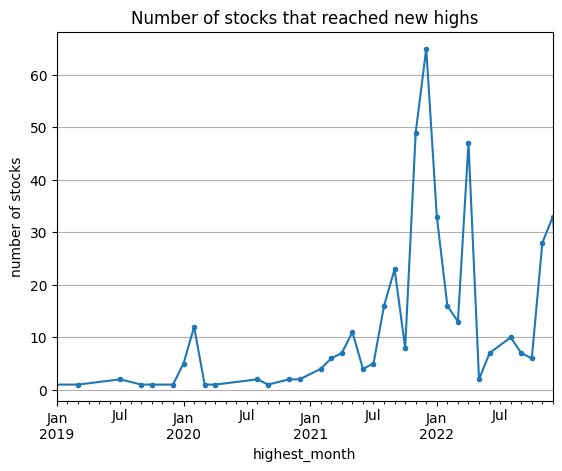

In [29]:
highest_day_count["ticker"].plot(marker=".")
plt.grid(axis='y')
plt.title("Number of stocks that reached new highs")
plt.xlim("2019-01-01", "2022-12-30")
plt.ylabel("number of stocks")
plt.show()

In [31]:
ticker_list = ["GOOG", "AAPL", "FB", "AMZN", "MSFT", "TSLA", "NVDA"]
df[df["ticker"].isin(ticker_list)]

,highest_day,ticker,highest_price,highest_month,Symbol,GICS Sector,GICS Sub-Industry
3,2022-01-03,AAPL,182.009995,2022-01,AAPL,Information Technology,"Technology Hardware, Storage & Peripherals"
34,2021-07-08,AMZN,186.570496,2021-07,AMZN,Consumer Discretionary,Internet & Direct Marketing Retail
206,2021-11-18,GOOG,150.709000,2021-11,GOOG,Communication Services,Interactive Media & Services
319,2021-11-19,MSFT,343.109985,2021-11,MSFT,Information Technology,Systems Software
340,2021-11-29,NVDA,333.760010,2021-11,NVDA,Information Technology,Semiconductors
449,2021-11-04,TSLA,409.970001,2021-11,TSLA,Consumer Discretionary,Automobile Manufacturers


In [ ]:
industry_value_counts = df[df["highest_day"] <= "2021-12